In [64]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import powerlaw
import sys

In [57]:
graph = {}
with open("human_interactome.csv", "r") as f:
    lines = f.read().splitlines() 
    for index in tqdm(range(len(lines))):
        line = lines[index]
        node_names = line.split(",")
        if (len(node_names) != 2):
            continue
        node1 = int(node_names[0])
        node2 = int(node_names[1])
        if (graph.get(node1) is None):
            graph[node1] = np.array([node2])
        else:
            graph[node1] = np.append(graph[node1], node2)
        if (graph.get(node2) is None):
            graph[node2] = np.array([node1])
        else:
            graph[node2] = np.append(graph[node2], node1)
        

100%|██████████| 342353/342353 [00:04<00:00, 76762.58it/s] 


In [58]:
# Number of nodes
print("Number of nodes: ", len(graph))

Number of nodes:  21557


In [59]:
# Number of edges
degree = np.array([])
for key in graph:
    degree = np.append(degree, len(graph[key]))
num_edge = np.sum(degree)
print("Number of edges: ", int(num_edge/2))

Number of edges:  342353


In [60]:
result = powerlaw.Fit(degree)
result.power_law.xmin

Calculating best minimal value for power law fit
c:\Users\a1085\miniconda3\envs\py311\Lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


234.0

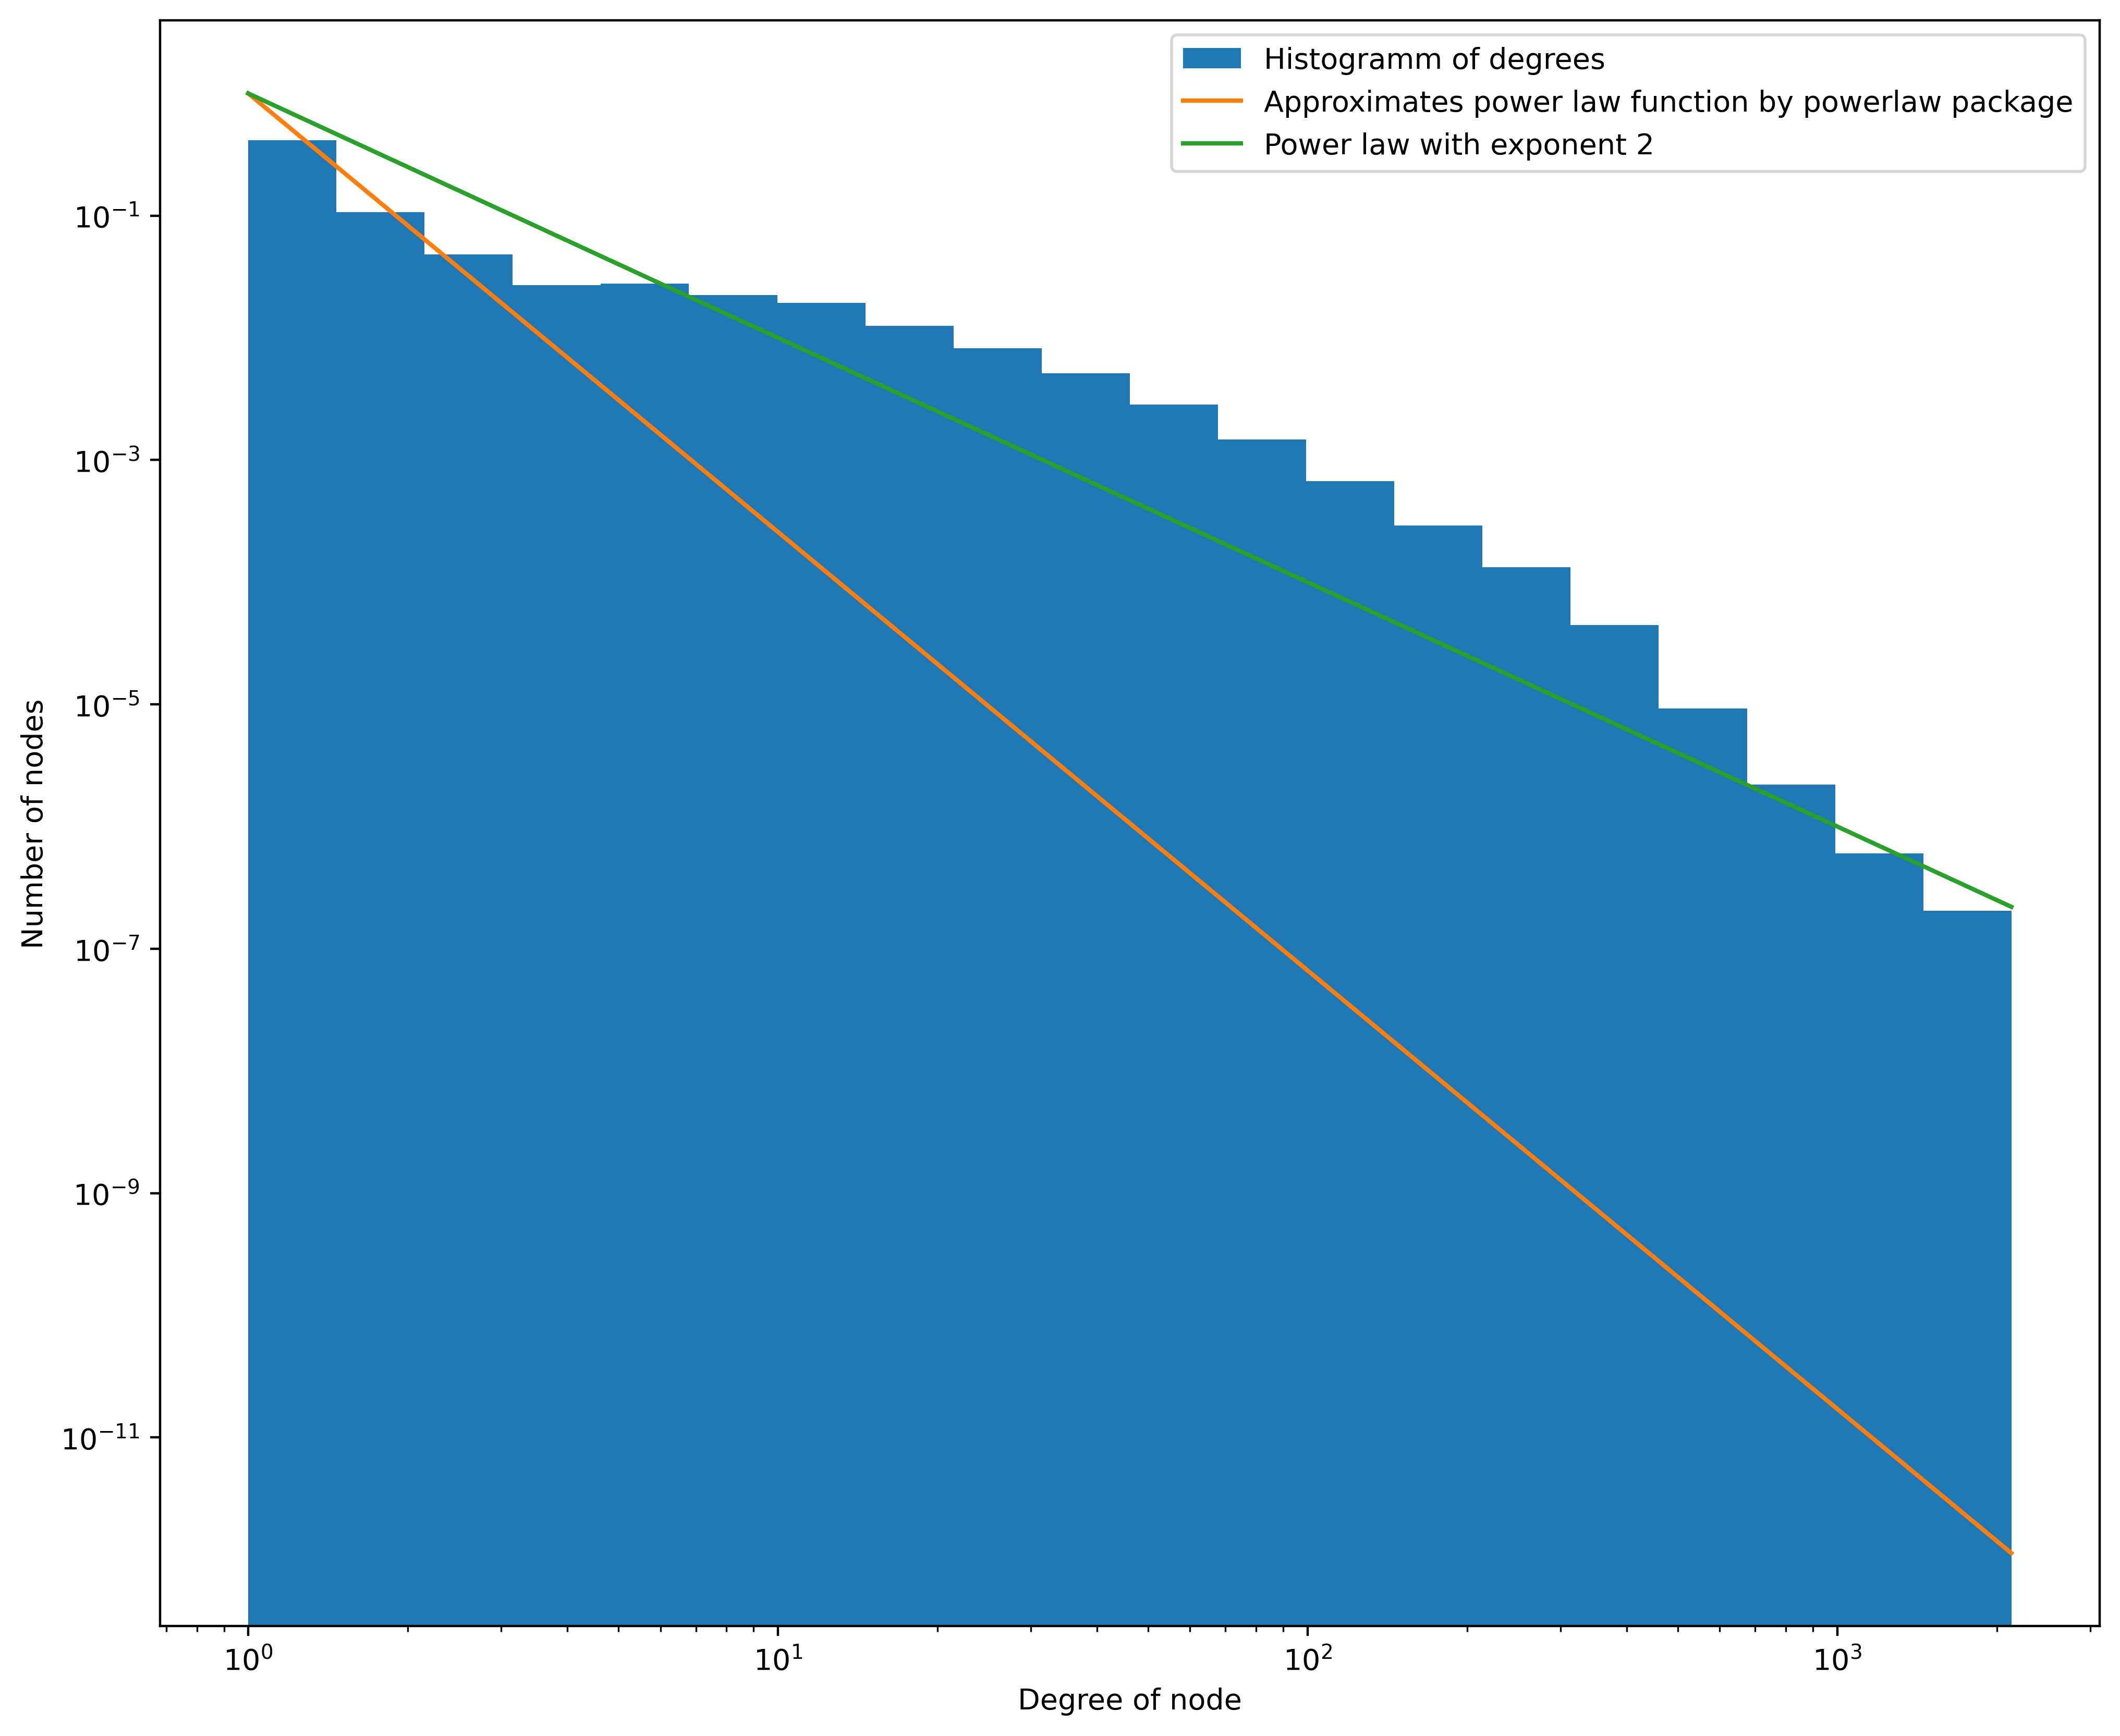

In [61]:
# Plot
# log_degree = pd.Series(np.log10(degree))
# hist, bins, _ = plt.hist(degree)
plt.figure(figsize=(12,10), dpi=400)
hist, bins = np.histogram(degree, bins=20)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(degree, bins=logbins, density=True, label="Histogramm of degrees")
x = np.arange(1, np.max(degree),1)
y = x ** (-result.power_law.alpha)
plt.plot(x,y,label="Approximates power law function by powerlaw package")
plt.plot(x, x**(-2), label="Power law with exponent 2")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree of node")
plt.ylabel("Number of nodes")
plt.legend()
plt.show()

In [62]:
def DFS(node, temp, visited):
    visited[node] = 1
    temp = np.append(temp, node)
    for i in graph[node]:
        if (visited.get(i) is None):
            temp, visited = DFS(i, temp, visited)
    return temp, visited

In [65]:
### Find connected components
sys.setrecursionlimit(len(graph))
nodes = list(graph)
visited = {}
cc = []
for i in tqdm(range(len(nodes)), desc="Searching for connected components"):
    if (visited.get(nodes[i]) is None):
        temp = np.array([])
        temp, visited = DFS(nodes[i], temp, visited)
        cc.append(temp)

Searching for connected components: 100%|██████████| 21557/21557 [00:00<00:00, 27052.10it/s]


In [66]:
length = []
for i in cc:
    length.append(len(i))

In [67]:
np.argmax(length)

0

In [68]:
cc_nodes = cc[np.argmax(length)]
    

In [69]:
len(cc_nodes)

21521

In [70]:
cc_num = len(cc_nodes)
num_samples = 100
srcs = np.random.choice(np.arange(cc_num), num_samples, replace = False)
distances = np.array([])
for i in tqdm(range(num_samples)):
    src = srcs[i]
    distance = np.ones(cc_num) * np.inf
    distance[src] = 0
    queue = [src]
    while (len(queue) != 0):
        current_node = queue.pop(0)
        # Check the neighbors of the current node
        for neighbor in graph[cc_nodes[current_node]]:
            index = np.where(cc_nodes == neighbor)[0][0]
            # Update the distance if it's smaller than the current value
            if (distance[index] > distance[current_node] + 1):
                distance[index] = distance[current_node] + 1
                queue.append(index)
    distances = np.append(distances, distance)

100%|██████████| 100/100 [56:10<00:00, 33.70s/it]  


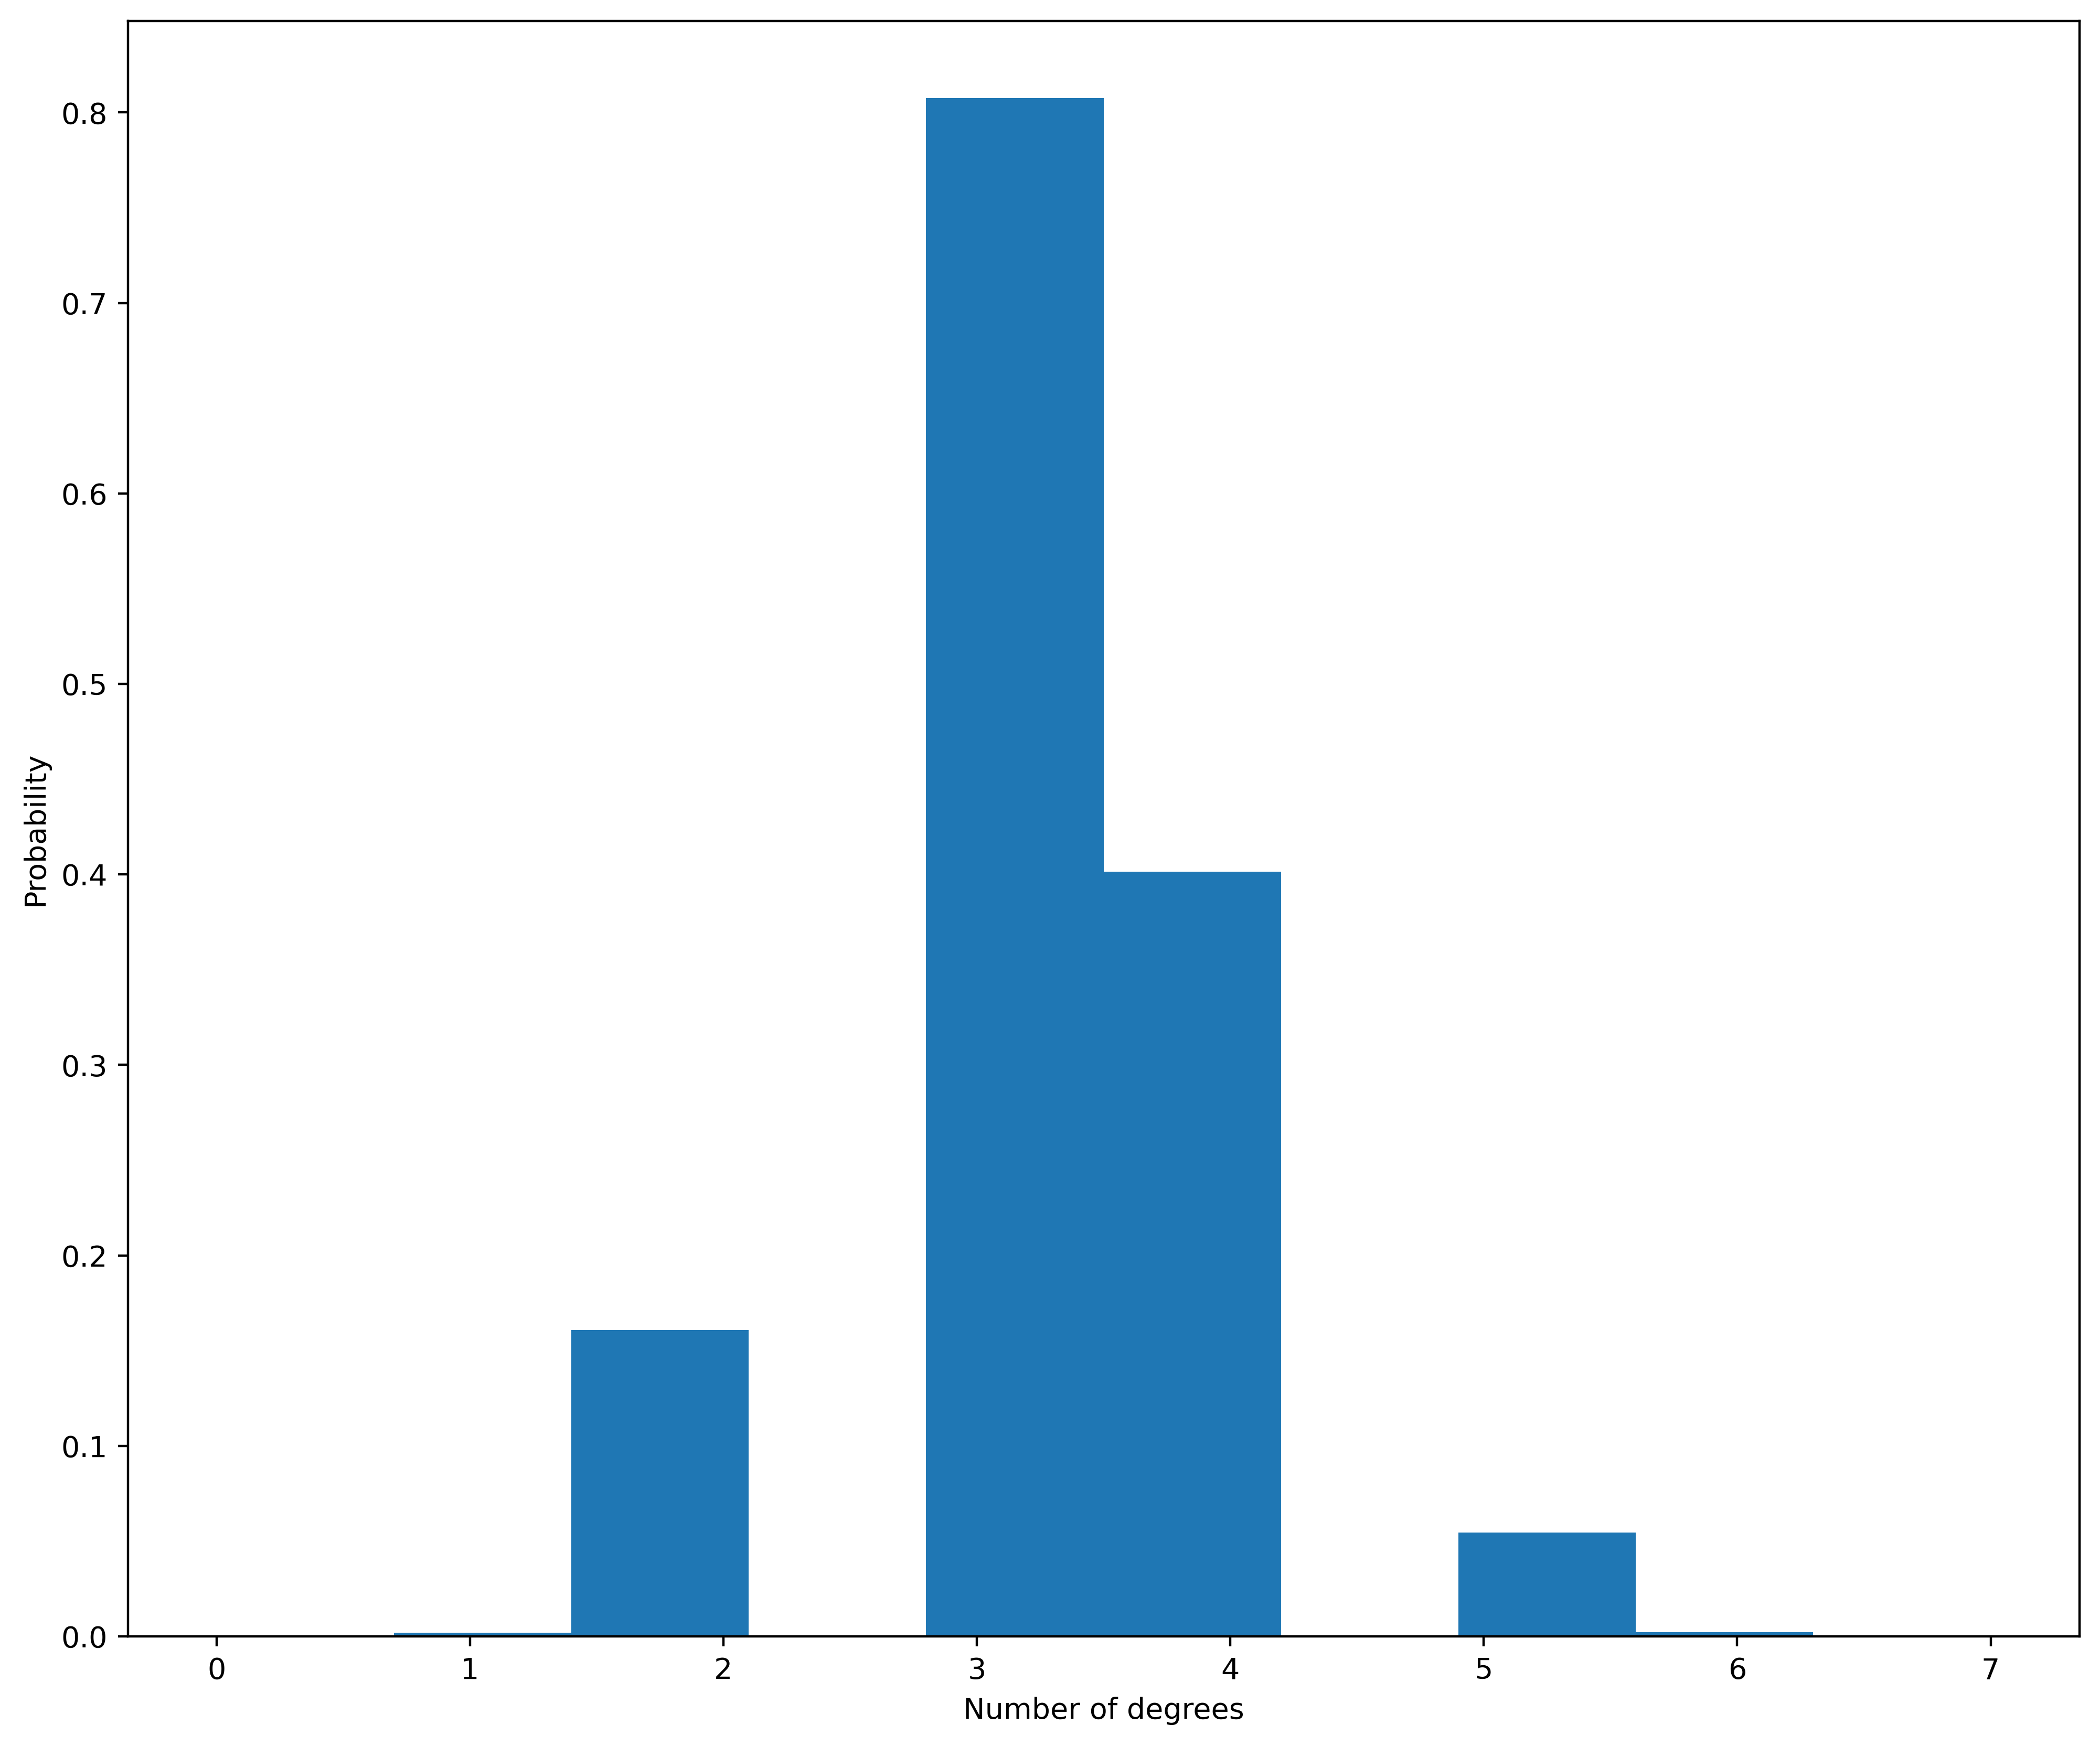

In [71]:
plt.figure(figsize=(12,10), dpi=400)
plt.hist(distances, density=True)
plt.xlabel("Number of degrees")
plt.ylabel("Probability")
plt.show()